<a href="https://www.kaggle.com/code/priyanagda/simple-gcn?scriptVersionId=117905567" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_sparse
import torch_scatter
import torch_geometric
import deepchem
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from torch_geometric.data import Dataset, download_url
import os
from tqdm import tqdm
from deepchem.feat import MolGraphConvFeaturizer
from deepchem.feat.graph_data import GraphData
from deepchem.data import NumpyDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [2]:
path = "/kaggle/input/bbbp-smiles/BBBP.csv"
df = pd.read_csv(path, usecols=[1,2,3])

In [3]:
smiles = df.smiles[1]
molecule = Chem.MolFromSmiles(smiles, sanitize=False)

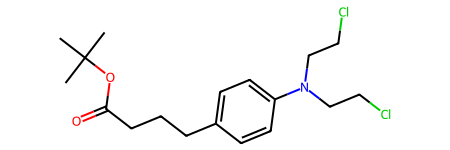

In [4]:
molecule

In [133]:

class MyOwnDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None, length=0):
        self.test = test
        self.filename = filename
        self.length = length
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped """
        processed_files = [f for f in os.listdir(self.processed_dir) if not f.startswith("pre")]
    
        if self.test:
            processed_files = [file for file in processed_files if "test" in file]
            if len(processed_files) == 0:
                return ["no_files.dummy"]
            length = len(processed_files)
            self.length = length
            return [f'data_test_{i}.pt' for i in list(range(length))]  # TODO: make sure the presence of file names with all data_i
        else:
            processed_files = [file for file in processed_files if not "test" in file]
            if len(processed_files) == 0:
                return ["no_files.dummy"]
            length = len(processed_files)
            self.length = length
            return [f'data_{i}.pt' for i in list(range(length))]

    def download(self):
        "Implement if needed to triger raw file download from the web."
        "Raw data file read from the raw directory."
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            # Featurize molecule
            try:
                f = featurizer.featurize(mol["smiles"])
                mol_graph = f[0]
                data = Data(x=mol_graph.node_features, edge_index=mol_graph.edge_index, pos=mol_graph.node_pos_features)
                count += 1
            except:
                continue
            data.y = mol["p_np"]  # binary classification label
            data.smiles = mol["smiles"]
            
            if self.test:
                torch.save(data, os.path.join(self.processed_dir, f"data_test_{count-1}.pt"))
            else:
                torch.save(data, os.path.join(self.processed_dir, f"data_{count-1}.pt"))
        print(f"Number of molecules included: {count}")

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [228]:
df.head()

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [239]:
X = df[["smiles", "name"]]
y = df[["p_np", "name"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df["p_np"])

In [240]:
train_df = X_train.merge(y_train)
test_df = X_test.merge(y_test)

In [241]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 1893 entries, 0 to 1892

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   smiles  1893 non-null   object

 1   name    1893 non-null   object

 2   p_np    1893 non-null   int64 

dtypes: int64(1), object(2)

memory usage: 59.2+ KB


In [242]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 207 entries, 0 to 206

Data columns (total 3 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   smiles  207 non-null    object

 1   name    207 non-null    object

 2   p_np    207 non-null    int64 

dtypes: int64(1), object(2)

memory usage: 6.5+ KB


In [243]:
test_df.to_csv("data/raw/test.csv", index=False)
train_df.to_csv("data/raw/train.csv", index=False)

In [247]:
train_dataset = MyOwnDataset("data", "train.csv", test=False)

Processing...

  1%|          | 20/1893 [00:00<00:19, 97.58it/s][22:34:10] Explicit valence for atom # 5 N, 4, is greater than permitted

Failed to featurize datapoint 0, None. Appending empty array

Exception message: Python argument types in

    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)

did not match C++ signature:

    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)

  2%|▏         | 30/1893 [00:00<00:19, 95.57it/s][22:34:10] Explicit valence for atom # 5 N, 4, is greater than permitted

Failed to featurize datapoint 0, None. Appending empty array

Exception message: Python argument types in

    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)

did not match C++ signature:

    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)

  2%|▏         | 40/1893 [00:00<00:19, 95.84it/s][22:34:10] Explicit valence for atom # 5 N, 4, is greater than permi

Number of molecules included: 1876




Done!


In [248]:
test_dataset = MyOwnDataset("data", "test.csv", test=True)

Processing...

  0%|          | 0/207 [00:00<?, ?it/s][22:34:31] WARNING: not removing hydrogen atom without neighbors

 41%|████      | 85/207 [00:00<00:01, 96.02it/s][22:34:32] WARNING: not removing hydrogen atom without neighbors

100%|██████████| 207/207 [00:02<00:00, 98.09it/s] 

Number of molecules included: 207




Done!


In [249]:
train_dataloader = DataLoader(train_dataset, 1)
test_dataloader = DataLoader(test_dataset, 1)

In [250]:
train_dataset

MyOwnDataset(1876)

In [251]:
test_dataset

MyOwnDataset(207)

In [263]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(train_dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        # print(np.array(x).shape)
        x = torch.tensor(x, dtype=torch.float32)
        edge_index = torch.tensor(np.squeeze(np.array(edge_index)))

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(

  (conv1): GCNConv(30, 64)

  (conv2): GCNConv(64, 64)

  (conv3): GCNConv(64, 64)

  (lin): Linear(in_features=64, out_features=2, bias=True)

)


In [264]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [266]:
def train():
    model.train()

    for data in train_dataloader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        y = torch.tensor([[0., 0.]])
        y[0][data.y.item()] = 1
        out = torch.flatten(out, start_dim=1)
        #  print(y, out)
        loss = criterion(out, y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
    return loss

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        out = torch.flatten(out, start_dim=1)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    loss = train()
    train_acc = test(train_dataloader)
    test_acc = test(test_dataloader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.5f} Train Acc: {train_acc:.5f}, Test Acc: {test_acc:.5f}')

Epoch: 001, Loss: 0.25178 Train Acc: 0.79797, Test Acc: 0.76812

Epoch: 002, Loss: 0.46958 Train Acc: 0.81823, Test Acc: 0.77778

Epoch: 003, Loss: 0.56947 Train Acc: 0.84542, Test Acc: 0.81159

Epoch: 004, Loss: 0.33016 Train Acc: 0.83529, Test Acc: 0.79710

Epoch: 005, Loss: 0.34579 Train Acc: 0.84488, Test Acc: 0.80676

Epoch: 006, Loss: 0.29618 Train Acc: 0.84435, Test Acc: 0.82609

Epoch: 007, Loss: 0.24954 Train Acc: 0.83582, Test Acc: 0.80193

Epoch: 008, Loss: 0.58266 Train Acc: 0.84648, Test Acc: 0.81643

Epoch: 009, Loss: 0.45900 Train Acc: 0.84542, Test Acc: 0.81643

Epoch: 010, Loss: 0.14506 Train Acc: 0.83369, Test Acc: 0.80193

Epoch: 011, Loss: 0.08958 Train Acc: 0.81397, Test Acc: 0.78744

Epoch: 012, Loss: 0.30856 Train Acc: 0.84808, Test Acc: 0.82126

Epoch: 013, Loss: 0.28060 Train Acc: 0.82623, Test Acc: 0.81159

Epoch: 014, Loss: 0.48426 Train Acc: 0.85501, Test Acc: 0.84058

Epoch: 015, Loss: 0.33809 Train Acc: 0.85075, Test Acc: 0.85024

Epoch: 016, Loss: 0.50505

In [222]:
df.p_np.value_counts()

1    1567
0     483
Name: p_np, dtype: int64